# Data Poisoning Attack Experiments

In [91]:
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN, HDBSCAN
import cv2
from scipy.fftpack import dct, idct
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [92]:
# Load MNIST dataset with PyTorch
transform = transforms.Compose([transforms.ToTensor()])  # Convert images to tensors
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

x_train = np.array([img.numpy().squeeze() for img, _ in mnist_train])  # shape: (N, 28, 28)
y_train = np.array([label for _, label in mnist_train])

In [ ]:
np.random.seed(2120)
first_show = np.random.choice(len(x_train), 10, replace=False)
first_show_labels = y_train[first_show]

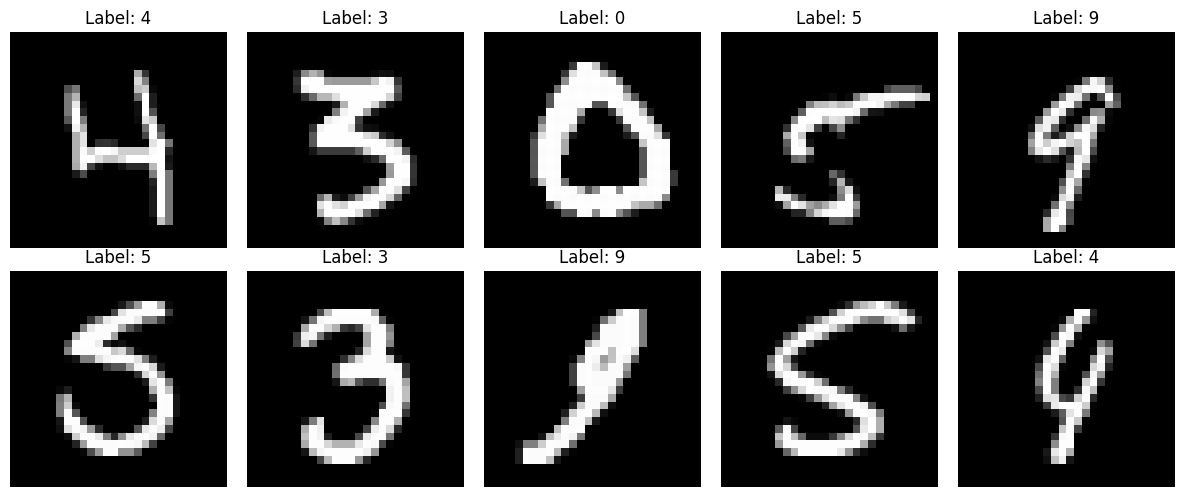

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 5))
axes = axes.flatten()

for ax, idx in zip(axes, first_show):
    ax.imshow(x_train[idx], cmap='gray')
    ax.set_title(f'Label: {y_train[idx]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

## Techniques

In [ ]:
np.random.seed(2120)
sample_indices = np.random.choice(len(x_train), 3, replace=False)

### 1. Label Flipping Attack

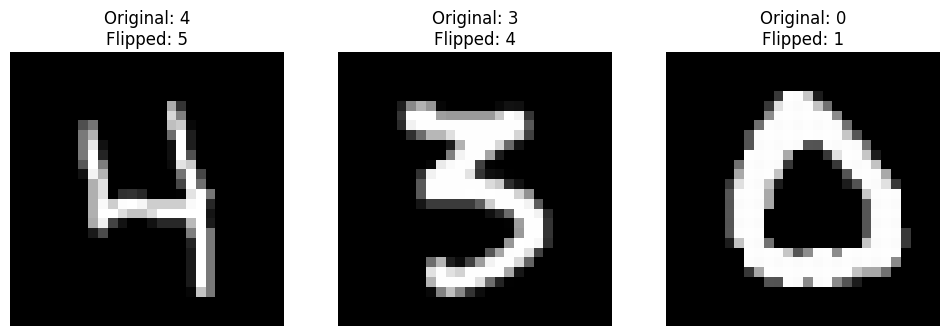

In [ ]:
original_labels = y_train[sample_indices]
# For demonstration, we flip the label by adding one modulo 10: (0 -> 1, 1 -> 2, etc.)
flipped_labels = (original_labels + 1) % 10

plt.figure(figsize=(12, 4))
for i, idx in enumerate(sample_indices):
    plt.subplot(1, 3, i + 1)
    plt.imshow(x_train[idx], cmap='gray')
    plt.title(f'Original: {original_labels[i]}\nFlipped: {flipped_labels[i]}')
    plt.axis('off')
plt.show()


### 2. Backdoor Attack (Trojan Attack)

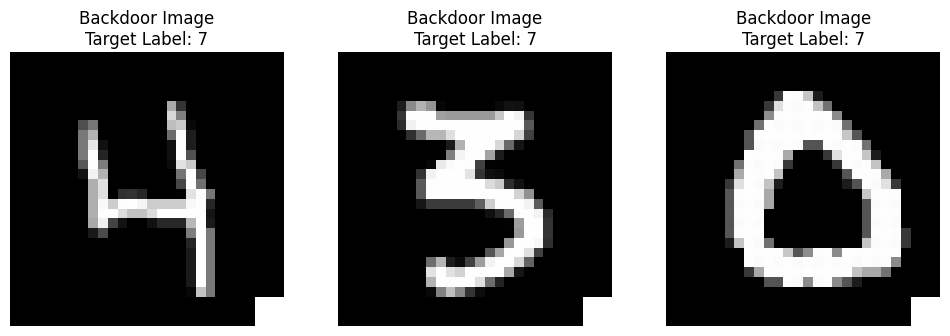

In [ ]:
backdoor_images = []
for idx in sample_indices:
    # Create a copy of the image
    img = np.copy(x_train[idx])
    # Insert a 3x3 white block in the bottom-right corner (trigger pattern)
    img[-3:, -3:] = 1
    backdoor_images.append(img)

target_label = 7  # This is the label assigned to all backdoor-triggered images

plt.figure(figsize=(12, 4))
for i, img in enumerate(backdoor_images):
    plt.subplot(1, 3, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f'Backdoor Image\nTarget Label: {target_label}')
    plt.axis('off')
plt.show()

### 3. Label Injection

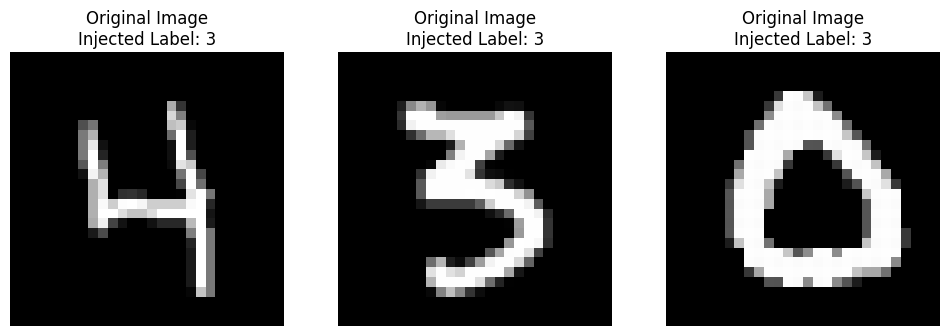

In [ ]:
target_label = 3  # The injected label for all these samples

plt.figure(figsize=(12, 4))
for i, idx in enumerate(sample_indices):
    plt.subplot(1, 3, i + 1)
    plt.imshow(x_train[idx], cmap='gray')
    plt.title(f'Original Image\nInjected Label: {target_label}')
    plt.axis('off')
plt.show()

### 4. Random Noise Injection

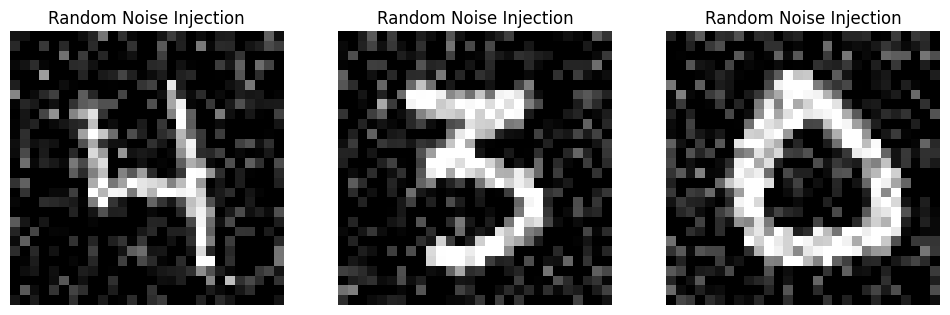

In [ ]:
noise_level = 0.2
random_noise_images = []
for idx in sample_indices:
    img = np.copy(x_train[idx])
    noise = np.random.normal(0, noise_level, img.shape)
    img_noisy = np.clip(img + noise, 0, 1)
    random_noise_images.append(img_noisy)

plt.figure(figsize=(12, 4))
for i, img in enumerate(random_noise_images):
    plt.subplot(1, 3, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title("Random Noise Injection")
    plt.axis('off')
plt.show()

## Large Scale

In [61]:
def data_poisoning(x_train, y_train, attack_type=None, sample=10000):
    if attack_type == "label_flipping":
        # Label Flipping Attack (Class Poisoning)
        poison_indices = np.random.choice(len(y_train), size=sample, replace=False)
        poisoned_labels = y_train[poison_indices]
        y_train[poison_indices] = (poisoned_labels + 1) % 10

    elif attack_type == "backdoor":
        # Backdoor Attack (Trojan Attack)
        poison_indices = np.random.choice(len(y_train), size=sample, replace=False)
        for i in poison_indices:
            x_train[i][:, -3:] = 0  # Add backdoor pattern
            y_train[i] = 7  # Label the poisoned data as "7"

    elif attack_type == "label_injection":
        # Label Injection (Targeted Poisoning)
        poison_indices = np.random.choice(len(y_train), size=sample, replace=False)
        y_train[poison_indices] = 8  # Label all poisoned data as "8"

    elif attack_type == "random_noise":
        # Random Noise Injection
        noise_level = 0.2
        poison_indices = np.random.choice(len(y_train), size=sample, replace=False)
        for i in poison_indices:
            noise = np.random.normal(0, noise_level, x_train[i].shape)
            x_train[i] = np.clip(x_train[i] + noise, 0, 1)  # Add noise and clip to valid pixel range

    elif attack_type == None:
        print("No attack applied.")

    else:
        raise ValueError(f"Unknown attack type: {attack_type}")

    return x_train, y_train

In [ ]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)  # Input layer (784 inputs for 28x28 images)
        self.fc2 = nn.Linear(128, 64)     # Hidden layer
        self.fc3 = nn.Linear(64, 10)      # Output layer (10 classes for digits 0-9)

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the image
        x = F.relu(self.fc1(x))  # ReLU activation for the first layer
        x = F.relu(self.fc2(x))  # ReLU activation for the second layer
        x = self.fc3(x)  # Output layer (logits)
        return x

# Training loop
def train(model, train_loader, test_loader, criterion, optimizer, epochs=5):
    train_acc_list = []
    test_acc_list = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_acc = 100 * correct_train / total_train
        train_acc_list.append(train_acc)

        # Evaluate on the test data after the epoch
        model.eval()
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()
        test_acc = 100 * correct_test / total_test
        test_acc_list.append(test_acc)

        print(f"Epoch {epoch+1}/{epochs} -> Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%")
    return train_acc_list, test_acc_list

# Confusion Matrix & Visualization
def get_confusion_matrix(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.append(predicted.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    cm = confusion_matrix(all_labels, all_preds)
    return cm, all_labels, all_preds

def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Get clean data arrays so that we can apply different attacks without interference
x_train_clean = mnist_train.data.numpy()  # shape: (N, 28, 28)
y_train_clean = mnist_train.targets.numpy()
x_test = mnist_test.data.numpy()
y_test = mnist_test.targets.numpy()

# Prepare test data loader
x_test_tensor = torch.tensor(x_test).float() / 255.0
y_test_tensor = torch.tensor(y_test).long()
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


Experiment with Attack: Clean
Running with 10000 samples...
No attack applied.
Epoch 1/5 -> Train Acc: 83.67%, Test Acc: 93.23%
Epoch 2/5 -> Train Acc: 94.24%, Test Acc: 95.12%
Epoch 3/5 -> Train Acc: 96.03%, Test Acc: 96.49%
Epoch 4/5 -> Train Acc: 96.97%, Test Acc: 97.09%
Epoch 5/5 -> Train Acc: 97.58%, Test Acc: 97.10%


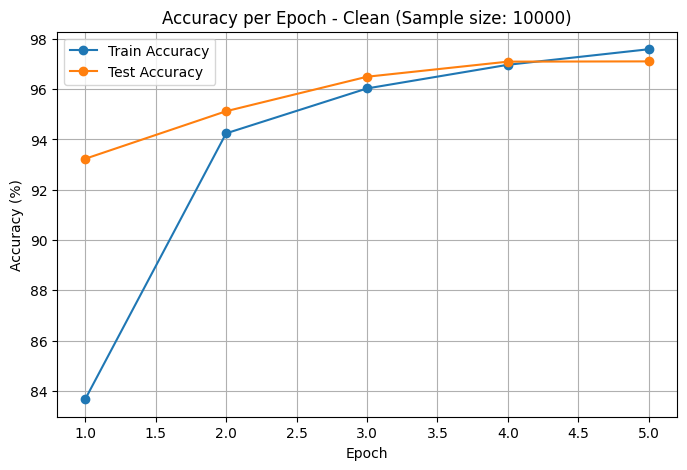

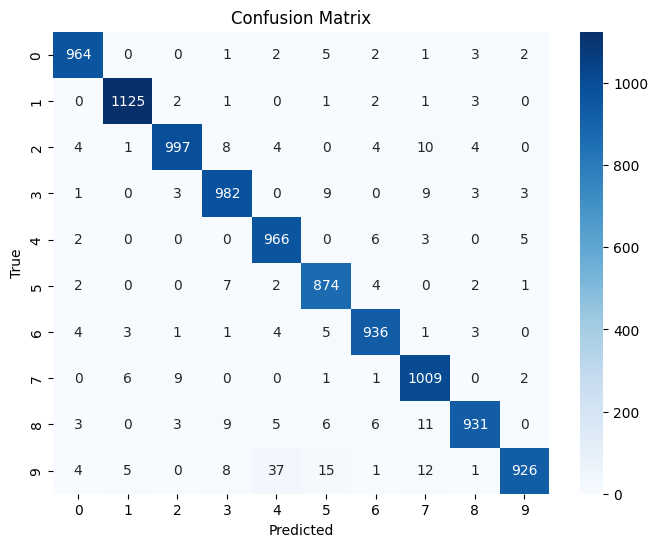

Running with 20000 samples...
No attack applied.
Epoch 1/5 -> Train Acc: 84.19%, Test Acc: 93.34%
Epoch 2/5 -> Train Acc: 94.21%, Test Acc: 95.13%
Epoch 3/5 -> Train Acc: 96.03%, Test Acc: 96.54%
Epoch 4/5 -> Train Acc: 97.02%, Test Acc: 96.65%
Epoch 5/5 -> Train Acc: 97.62%, Test Acc: 97.32%


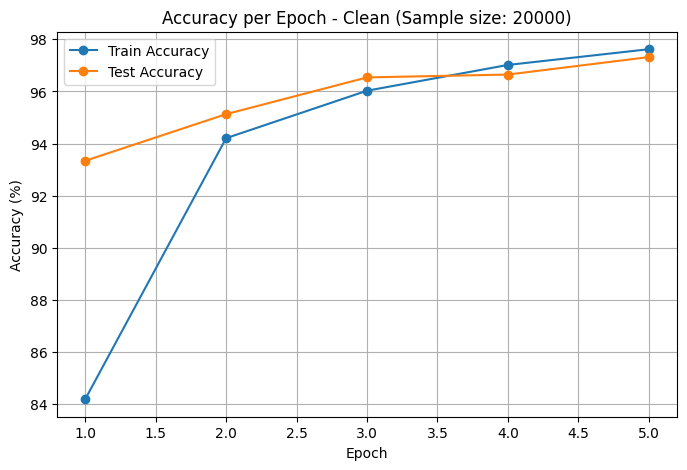

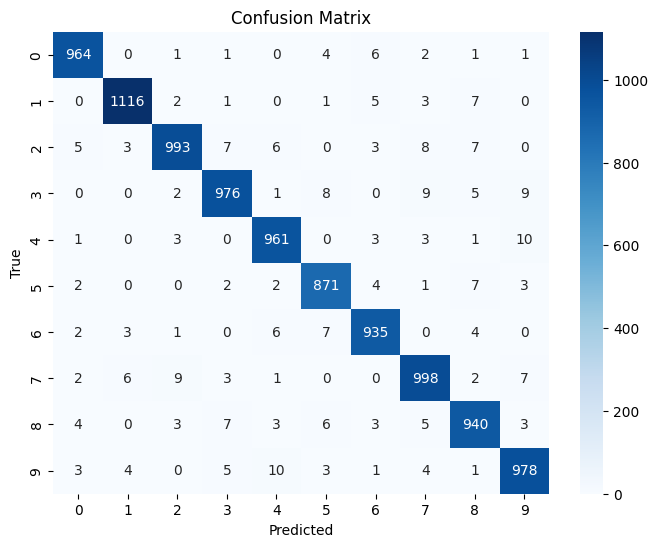

Running with 30000 samples...
No attack applied.
Epoch 1/5 -> Train Acc: 83.84%, Test Acc: 93.12%
Epoch 2/5 -> Train Acc: 94.06%, Test Acc: 95.64%
Epoch 3/5 -> Train Acc: 96.05%, Test Acc: 96.23%
Epoch 4/5 -> Train Acc: 96.97%, Test Acc: 96.89%
Epoch 5/5 -> Train Acc: 97.61%, Test Acc: 96.85%


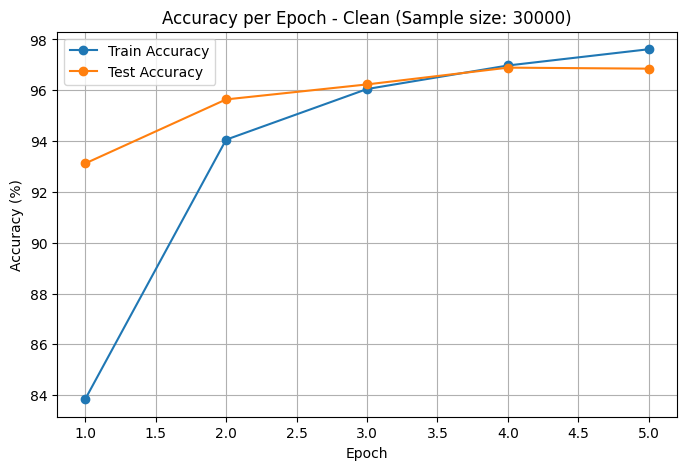

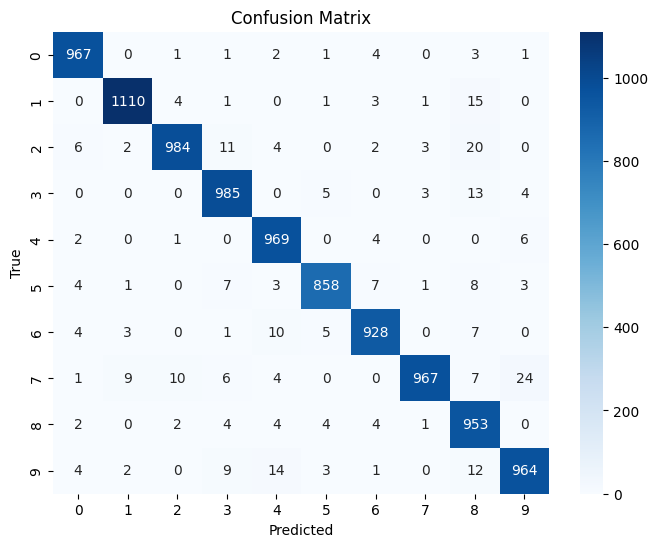


Experiment with Attack: label_flipping
Running with 10000 samples...
Epoch 1/5 -> Train Acc: 67.74%, Test Acc: 91.70%
Epoch 2/5 -> Train Acc: 78.17%, Test Acc: 95.19%
Epoch 3/5 -> Train Acc: 79.66%, Test Acc: 95.96%
Epoch 4/5 -> Train Acc: 80.48%, Test Acc: 96.47%
Epoch 5/5 -> Train Acc: 80.95%, Test Acc: 96.84%


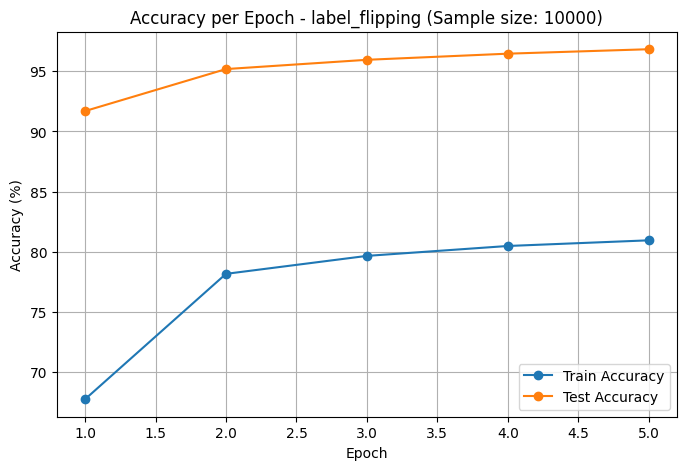

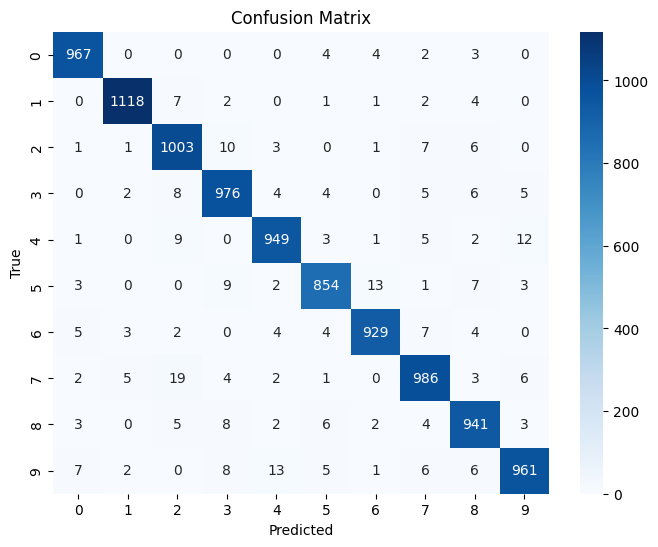

Running with 20000 samples...
Epoch 1/5 -> Train Acc: 41.89%, Test Acc: 73.47%
Epoch 2/5 -> Train Acc: 50.00%, Test Acc: 71.75%
Epoch 3/5 -> Train Acc: 51.33%, Test Acc: 68.62%
Epoch 4/5 -> Train Acc: 52.11%, Test Acc: 80.38%
Epoch 5/5 -> Train Acc: 52.81%, Test Acc: 74.90%


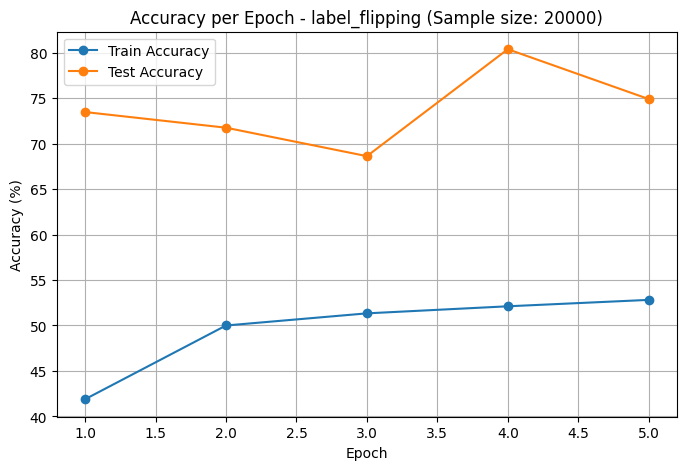

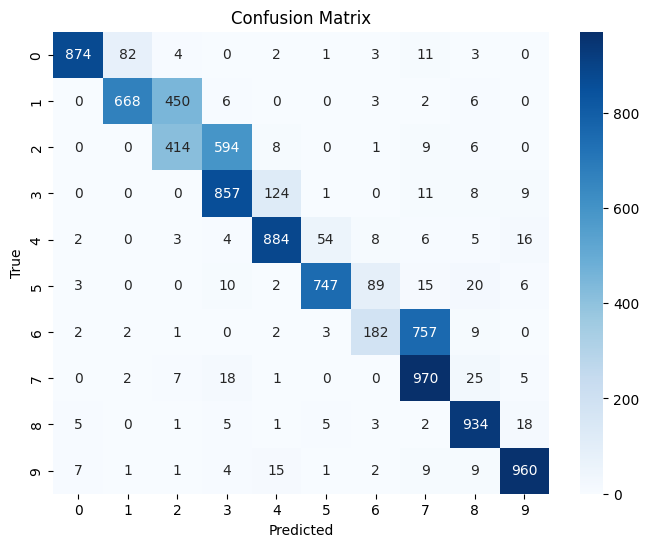

Running with 30000 samples...
Epoch 1/5 -> Train Acc: 36.61%, Test Acc: 7.23%
Epoch 2/5 -> Train Acc: 42.89%, Test Acc: 6.99%
Epoch 3/5 -> Train Acc: 44.11%, Test Acc: 10.56%
Epoch 4/5 -> Train Acc: 44.63%, Test Acc: 5.43%
Epoch 5/5 -> Train Acc: 44.93%, Test Acc: 4.59%


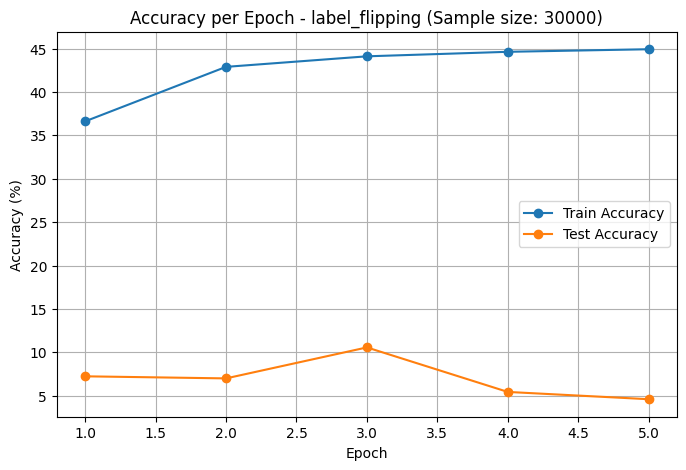

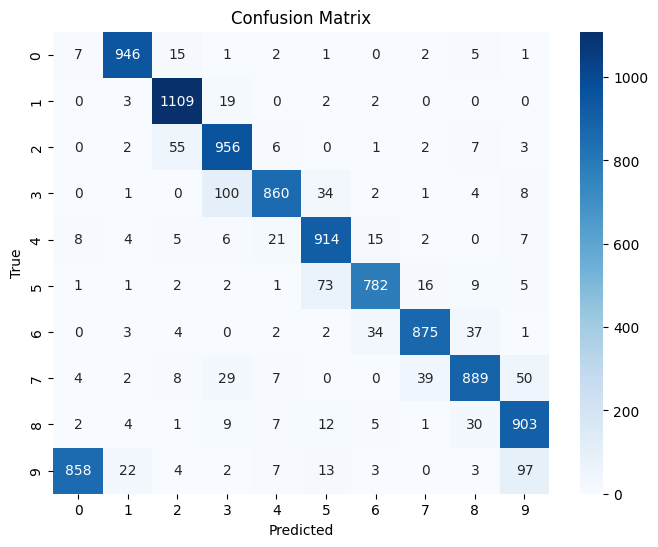


Experiment with Attack: backdoor
Running with 10000 samples...
Epoch 1/5 -> Train Acc: 68.40%, Test Acc: 90.47%
Epoch 2/5 -> Train Acc: 78.91%, Test Acc: 92.80%
Epoch 3/5 -> Train Acc: 80.84%, Test Acc: 95.07%
Epoch 4/5 -> Train Acc: 81.84%, Test Acc: 95.46%
Epoch 5/5 -> Train Acc: 82.45%, Test Acc: 96.43%


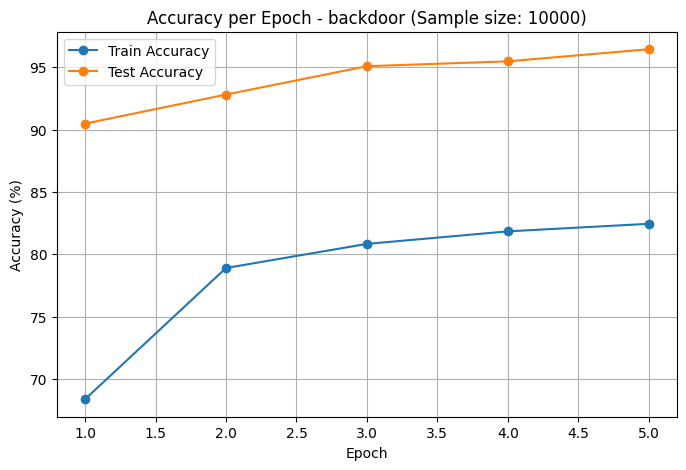

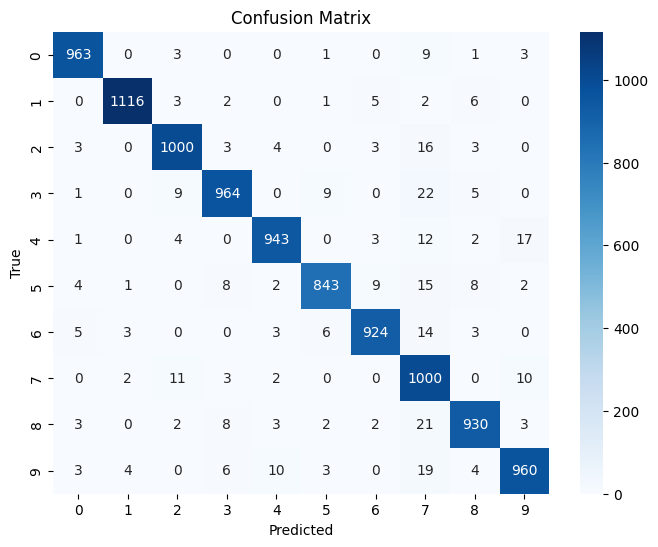

Running with 20000 samples...
Epoch 1/5 -> Train Acc: 53.00%, Test Acc: 44.52%
Epoch 2/5 -> Train Acc: 55.91%, Test Acc: 57.48%
Epoch 3/5 -> Train Acc: 56.88%, Test Acc: 68.57%
Epoch 4/5 -> Train Acc: 57.88%, Test Acc: 72.97%
Epoch 5/5 -> Train Acc: 58.82%, Test Acc: 83.20%


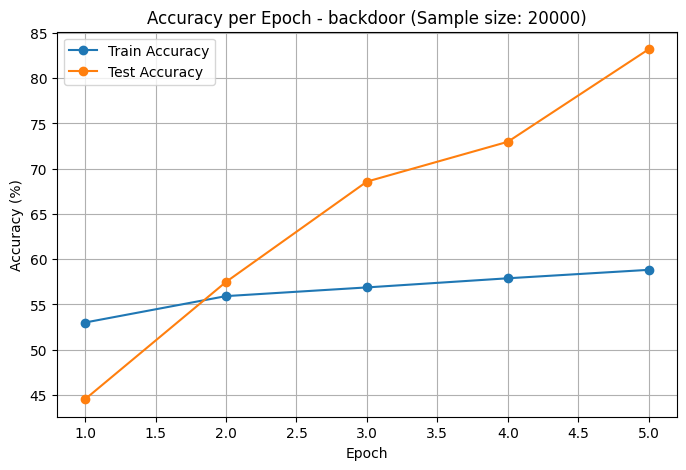

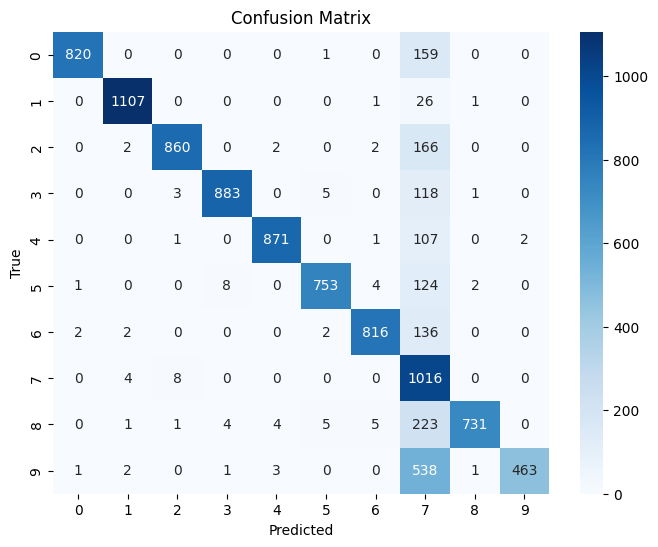

Running with 30000 samples...
Epoch 1/5 -> Train Acc: 74.33%, Test Acc: 10.29%
Epoch 2/5 -> Train Acc: 74.42%, Test Acc: 10.75%
Epoch 3/5 -> Train Acc: 74.57%, Test Acc: 10.29%
Epoch 4/5 -> Train Acc: 74.74%, Test Acc: 11.59%
Epoch 5/5 -> Train Acc: 74.91%, Test Acc: 10.66%


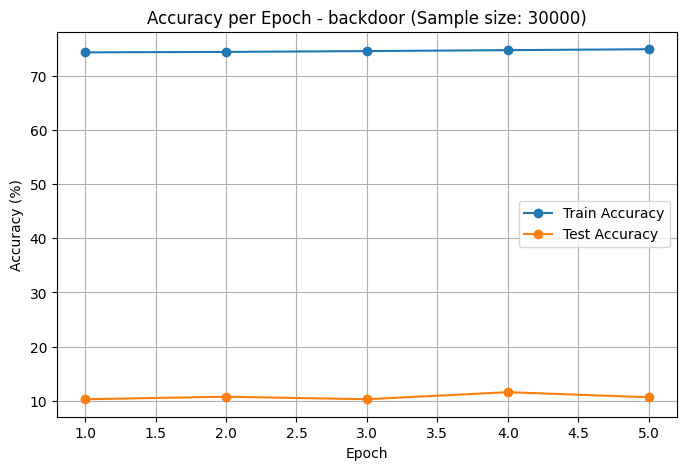

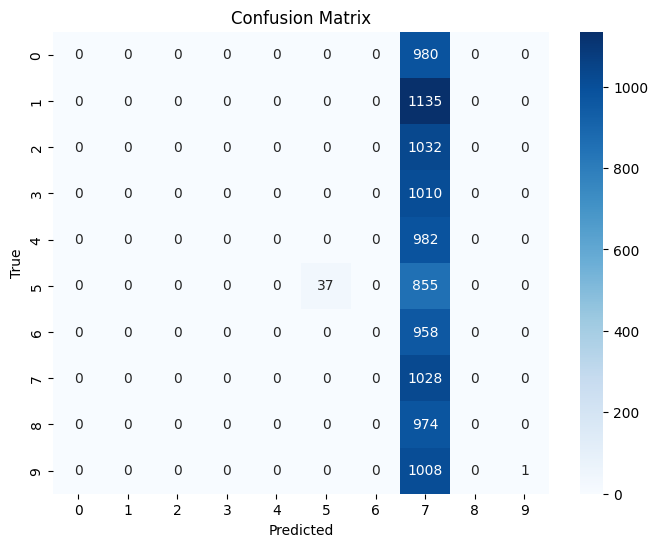


Experiment with Attack: label_injection
Running with 10000 samples...
Epoch 1/5 -> Train Acc: 67.84%, Test Acc: 88.02%
Epoch 2/5 -> Train Acc: 78.68%, Test Acc: 93.39%
Epoch 3/5 -> Train Acc: 80.44%, Test Acc: 95.43%
Epoch 4/5 -> Train Acc: 81.41%, Test Acc: 94.87%
Epoch 5/5 -> Train Acc: 81.88%, Test Acc: 94.18%


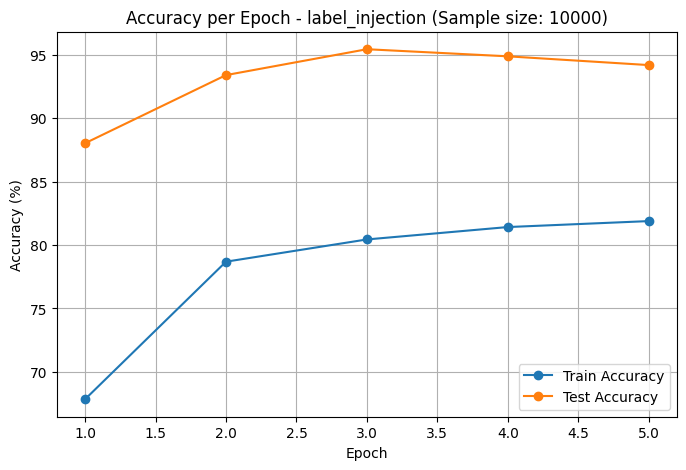

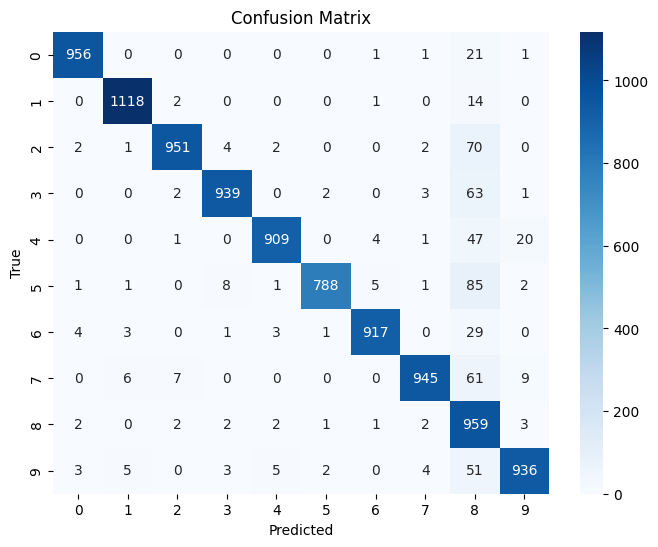

Running with 20000 samples...
Epoch 1/5 -> Train Acc: 53.11%, Test Acc: 59.49%
Epoch 2/5 -> Train Acc: 55.17%, Test Acc: 54.41%
Epoch 3/5 -> Train Acc: 56.37%, Test Acc: 77.83%
Epoch 4/5 -> Train Acc: 57.10%, Test Acc: 74.04%
Epoch 5/5 -> Train Acc: 57.59%, Test Acc: 74.42%


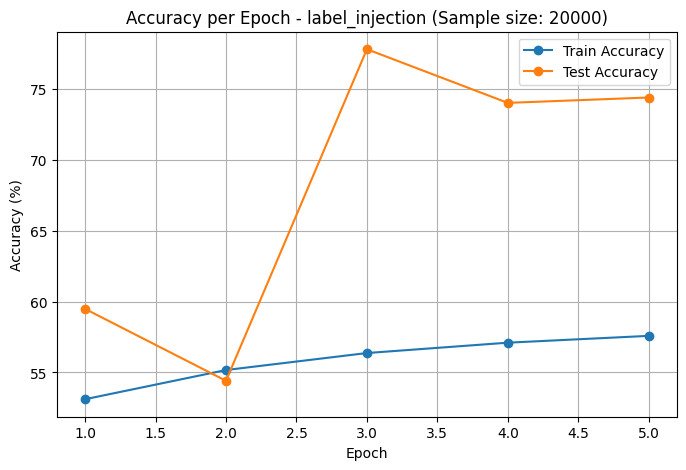

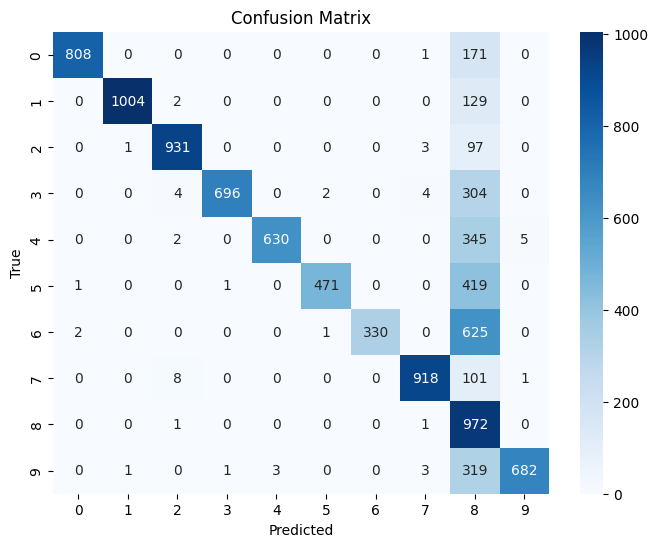

Running with 30000 samples...
Epoch 1/5 -> Train Acc: 74.62%, Test Acc: 9.79%
Epoch 2/5 -> Train Acc: 74.58%, Test Acc: 11.61%
Epoch 3/5 -> Train Acc: 74.64%, Test Acc: 10.16%
Epoch 4/5 -> Train Acc: 74.71%, Test Acc: 10.52%
Epoch 5/5 -> Train Acc: 74.82%, Test Acc: 9.77%


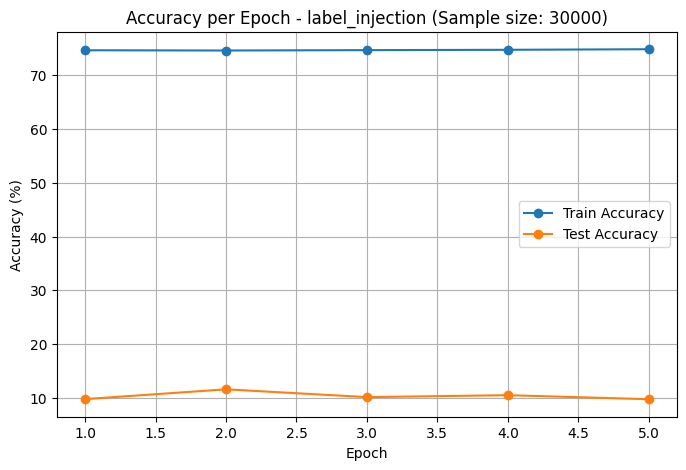

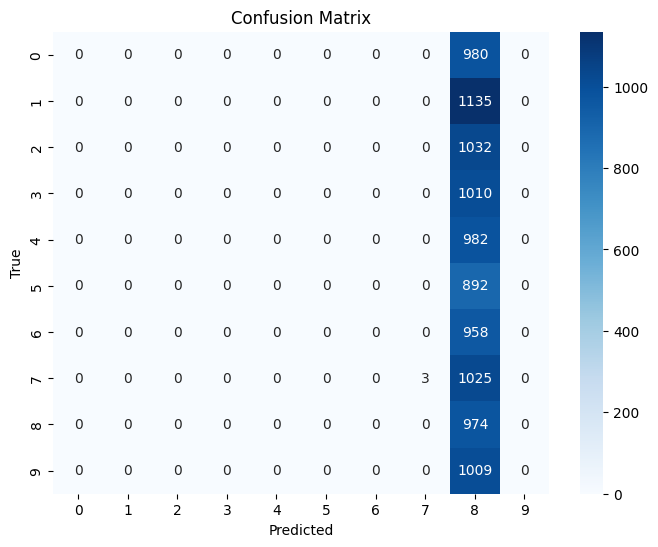


Experiment with Attack: random_noise
Running with 10000 samples...
Epoch 1/5 -> Train Acc: 71.14%, Test Acc: 92.67%
Epoch 2/5 -> Train Acc: 81.29%, Test Acc: 94.94%
Epoch 3/5 -> Train Acc: 83.14%, Test Acc: 96.15%
Epoch 4/5 -> Train Acc: 84.11%, Test Acc: 96.40%
Epoch 5/5 -> Train Acc: 85.06%, Test Acc: 96.71%


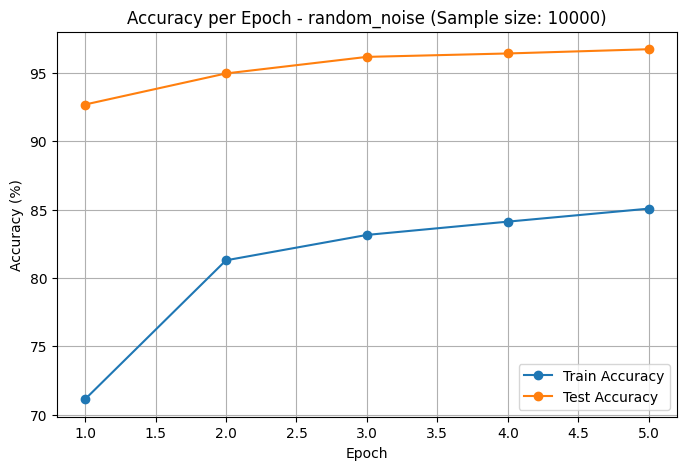

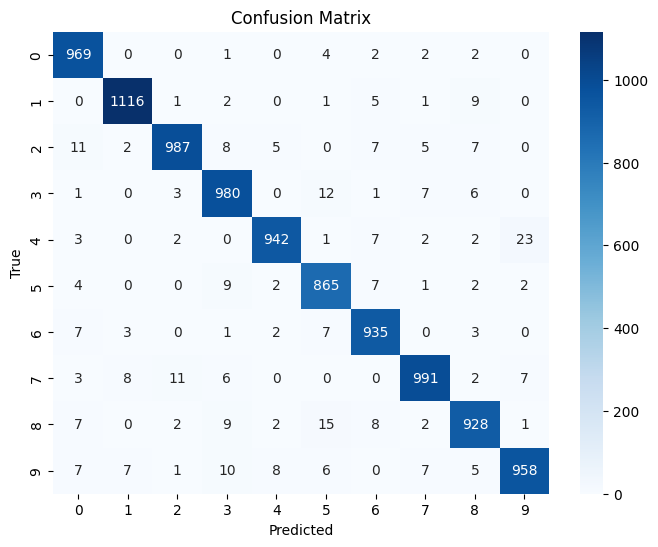

Running with 20000 samples...
Epoch 1/5 -> Train Acc: 51.09%, Test Acc: 90.58%
Epoch 2/5 -> Train Acc: 59.62%, Test Acc: 93.76%
Epoch 3/5 -> Train Acc: 63.54%, Test Acc: 94.79%
Epoch 4/5 -> Train Acc: 64.13%, Test Acc: 95.28%
Epoch 5/5 -> Train Acc: 66.28%, Test Acc: 95.41%


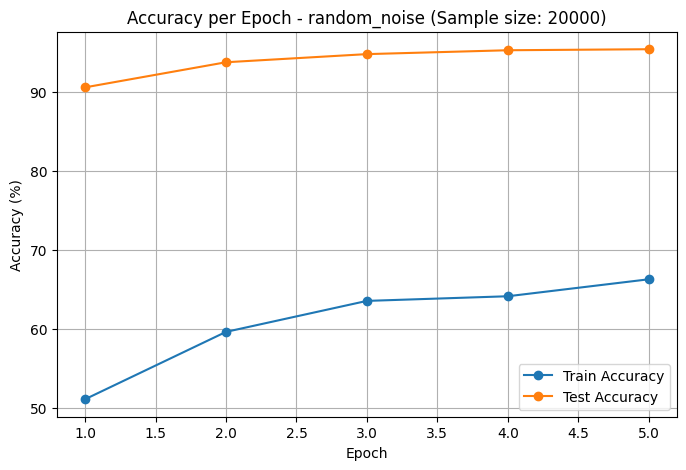

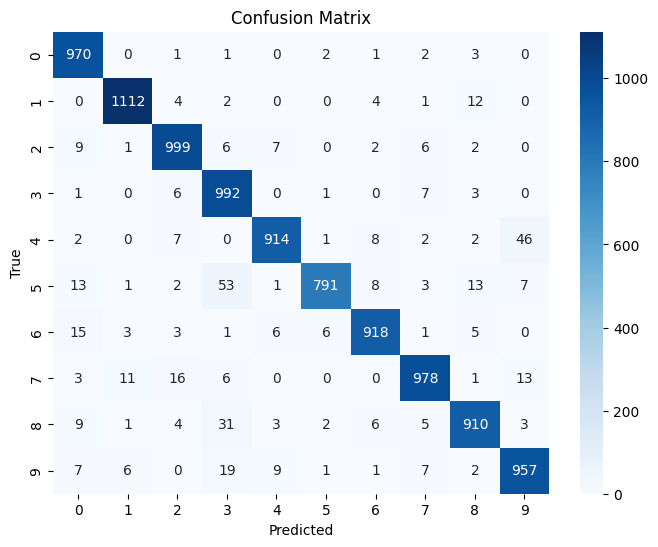

Running with 30000 samples...
Epoch 1/5 -> Train Acc: 29.33%, Test Acc: 88.31%
Epoch 2/5 -> Train Acc: 37.81%, Test Acc: 90.85%
Epoch 3/5 -> Train Acc: 41.25%, Test Acc: 92.21%
Epoch 4/5 -> Train Acc: 44.02%, Test Acc: 92.98%
Epoch 5/5 -> Train Acc: 49.51%, Test Acc: 93.78%


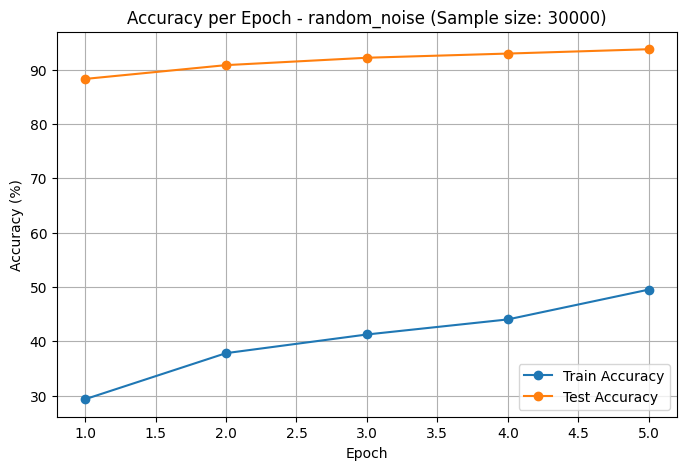

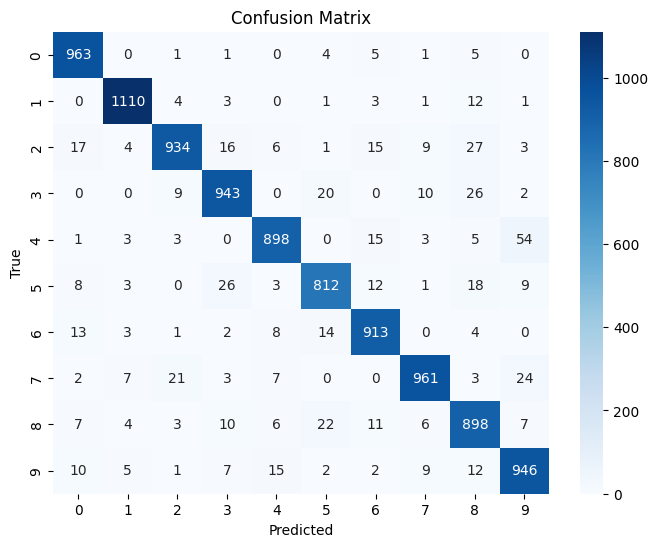


Benchmark Results:
       Attack Type 10000 Sample Accuracy (%) 20000 Sample Accuracy (%)  \
0            Clean                     97.10                     97.32   
1   label_flipping                     96.84                     74.90   
2         backdoor                     96.43                     83.20   
3  label_injection                     94.18                     74.42   
4     random_noise                     96.71                     95.41   

  30000 Sample Accuracy (%)  
0                     96.85  
1                      4.59  
2                     10.66  
3                      9.77  
4                     93.78  


In [ ]:
attack_types = [None, "label_flipping", "backdoor", "label_injection", "random_noise"]

benchmark_results = []

# Loop through each attack type
for attack in attack_types:
    print("\n==========================================")
    print(f"Experiment with Attack: {attack if attack is not None else 'Clean'}")

    # Deep copy clean data so each experiment starts fresh.
    x_train = x_train_clean.copy()
    y_train = y_train_clean.copy()

    # Loop through different sample sizes
    sample_sizes = [10000, 20000, 30000]

    # Store results for each attack type
    results = {"Attack Type": attack if attack is not None else "Clean"}

    for sample_size in sample_sizes:
        print(f"Running with {sample_size} samples...")

        # Apply the poisoning attack (if any)
        x_train_poisoned, y_train_poisoned = data_poisoning(x_train, y_train, attack_type=attack, sample=sample_size)

        # Prepare training data loader
        x_train_tensor = torch.tensor(x_train_poisoned).float() / 255.0
        y_train_tensor = torch.tensor(y_train_poisoned).long()
        train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

        # Initialize model, criterion, and optimizer
        model = NN()
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

        # Train the model over several epochs while recording accuracies for plotting
        epochs = 5
        train_acc_list, test_acc_list = train(model, train_loader, test_loader, criterion, optimizer, epochs=epochs)

        # Plot training and test accuracy curves
        plt.figure(figsize=(8,5))
        epochs_range = range(1, epochs+1)
        plt.plot(epochs_range, train_acc_list, marker='o', label='Train Accuracy')
        plt.plot(epochs_range, test_acc_list, marker='o', label='Test Accuracy')
        plt.title(f"Accuracy per Epoch - {attack if attack is not None else 'Clean'} (Sample size: {sample_size})")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy (%)")
        plt.legend()
        plt.grid(True)
        plt.show()

        # Compute and display the confusion matrix & per-class metrics
        cm, all_labels, all_preds = get_confusion_matrix(model, test_loader)
		# print("Classification Report:")
		# print(classification_report(all_labels, all_preds, target_names=[str(i) for i in range(10)]))
        plot_confusion_matrix(cm, classes=[str(i) for i in range(10)])

        # Store final test accuracy in results dictionary
        final_test_acc = test_acc_list[-1]
        results[f"{sample_size} Sample Accuracy (%)"] = f"{final_test_acc:.2f}"

    # Add the results for this attack type into benchmark_results
    benchmark_results.append(results)

# Display benchmark results using a pandas DataFrame.
df_benchmark = pd.DataFrame(benchmark_results)
print("\nBenchmark Results:")
print(df_benchmark)

## Weights

In [195]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from scipy.fftpack import dct
import hdbscan
from sklearn.decomposition import PCA
import seaborn as sns
from matplotlib.colors import ListedColormap

# Function to compute DCT on weights
def compute_2d_dct(weights):
    return dct(dct(weights.T, norm='ortho').T, norm='ortho')

# Extract low-frequency features from weights
def extract_low_freq_features(weights, block_size=8):
    dct_weights = compute_2d_dct(weights)
    features = dct_weights[:block_size, :block_size].flatten()
    return features

# Visualize the results of HDBSCAN clustering
def visualize_hdbscan_clusters(X, labels, title):
    # Reduce dimensions to 2 using PCA if necessary for visualization
    if X.shape[1] > 2:
        X = PCA(n_components=2).fit_transform(X)

    # Create a colormap (cluster labels with outliers labeled as red)
    unique_labels = np.unique(labels)
    colors = sns.color_palette('hsv', len(unique_labels) - 1)
    colors.insert(0, 'red')  # Red for outliers (-1)
    cmap = ListedColormap(colors)

    # Scatter plot to visualize all weights
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap=cmap, s=50, alpha=0.7)
    plt.title(title)
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.colorbar()
    plt.grid(True)
    plt.show()

# Define the model (Simple Neural Network)
class NN(torch.nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.fc1 = torch.nn.Linear(28*28, 128)  # Input layer (784 inputs for 28x28 images)
        self.fc2 = torch.nn.Linear(128, 64)     # Hidden layer
        self.fc3 = torch.nn.Linear(64, 10)      # Output layer (10 classes for digits 0-9)

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the image
        x = torch.relu(self.fc1(x))  # ReLU activation for the first layer
        x = torch.relu(self.fc2(x))  # ReLU activation for the second layer
        x = self.fc3(x)  # Output layer (logits)
        return x


# Simulate poisoning attack by modifying some weights randomly (same attack applied to 3 clients)
def simulate_poisoning_attack(weights, poisoning_rate=0.5):
    num_poisoned = int(weights.shape[0] * poisoning_rate)  # Number of poisoned weights
    poisoned_indices = np.random.choice(weights.shape[0], num_poisoned, replace=False)

    # Simulate poison by modifying these weights
    for idx in poisoned_indices:
        weights[idx] += np.random.normal(0, 10.0, weights[idx].shape)
    return weights

def visualize_dct(weights, ax, title="DCT Visualization"):
    dct_weights = compute_2d_dct(weights)
    dct_weights = dct_weights[:16, :16]
    im = ax.imshow(dct_weights, cmap='viridis', aspect='auto')
    ax.set_title(title)
    plt.colorbar(im, ax=ax)

In [166]:
# Load MNIST data
transform = transforms.ToTensor()
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

images = mnist_train.data.numpy()
labels = mnist_train.targets.numpy()

# Simulate multiple clients (10 clients)
num_clients = 20
all_weights = []
for client in range(num_clients):
    model = NN()
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    if client < 3:
        poisoned_images, poisoned_labels = data_poisoning(images, labels, attack_type="label_flipping", sample=30000)
        poisoned_images = torch.tensor(poisoned_images)
        images, labels = poisoned_images, poisoned_labels

    # Train the model for 3 epochs
    epochs = 5
    for epoch in range(epochs):
        model.train()
        for i in range(0, len(images), 100):
            batch_images = torch.tensor(images[i:i+100])
            batch_labels = torch.tensor(labels[i:i+100])
            optimizer.zero_grad()
            outputs = model(batch_images.float())
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()

    # Extract the model's weights for this client (using the first fully connected layer)
    weights = model.fc1.weight.detach().numpy()
    all_weights.append(weights)


<ipython-input-166-9fd611f929f6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_images = torch.tensor(images[i:i+100])
<ipython-input-166-9fd611f929f6>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  poisoned_images = torch.tensor(poisoned_images)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


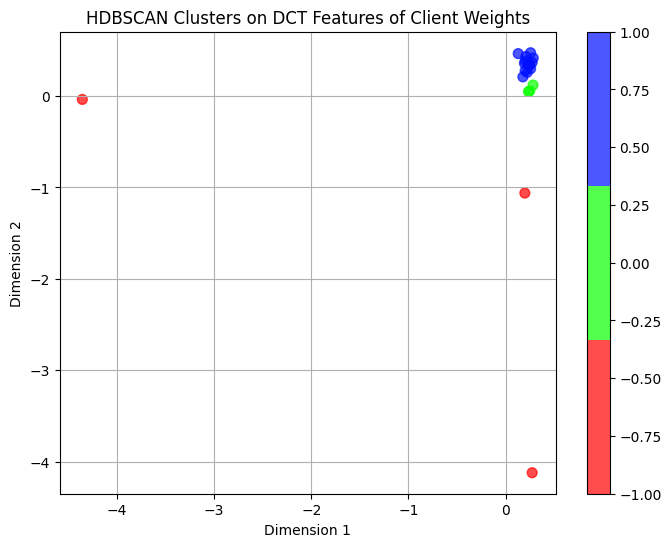

HDBSCAN Detected Outliers: [0 2 5]


In [176]:
features = []
for weights in all_weights:
    features.append(extract_low_freq_features(weights, block_size=10))

# Convert features to a numpy array
features = np.array(features)
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_pca)

# Apply HDBSCAN to Features with adjusted parameters
clusterer = hdbscan.HDBSCAN(min_cluster_size=2, min_samples=1)
labels_hdbscan = clusterer.fit_predict(features_scaled)

# Visualize the HDBSCAN clustering results
visualize_hdbscan_clusters(features_scaled, labels_hdbscan, title="HDBSCAN Clusters on DCT Features of Client Weights")

# Detect outliers using HDBSCAN (label -1 means outlier)
outlier_indices_hdbscan = np.where(labels_hdbscan == -1)[0]
print(f"HDBSCAN Detected Outliers: {outlier_indices_hdbscan}")

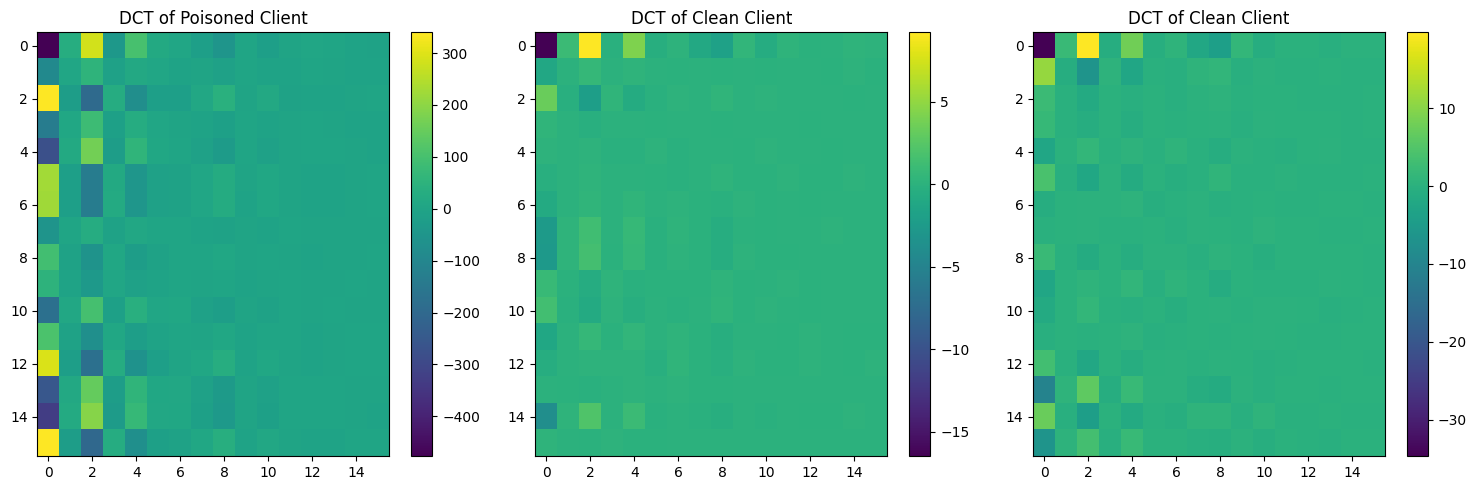

In [196]:
weights_client_1 = all_weights[0]  # Poisoned client
weights_client_2 = all_weights[4]  # Clean client
weights_client_3 = all_weights[7]  # Clean client

# Create a figure with 1 row and 3 columns for subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Visualize the DCT of poisoned and unpoisoned weights in a row
visualize_dct(weights_client_1, axes[0], title="DCT of Poisoned Client")
visualize_dct(weights_client_2, axes[1], title="DCT of Clean Client")
visualize_dct(weights_client_3, axes[2], title="DCT of Clean Client")

# Show the plot
plt.tight_layout()
plt.show()